######################################################################

<span style="font-size:30pt;font-family:Advent">Carbon Metalenses - Ultimate</span>
######################################################################

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import os
import uuid
import subprocess
import pickle
import time
import sys
sys.path.append(os.getcwd())
from matplotlib.colors import LogNorm
%reload_ext autoreload
%autoreload 2
from metalens import *
import datetime
from tabulate import tabulate

Using MPI version 3.1, 1 processes


# On-Axis

## function defs

In [2]:
# migrated to meepmeep.py on Apr 12 2019

## Just a single wave in vaccum

In [58]:
# Setup the MEEP objects
vac_width = 20
vac_height = 20
source_y = 0
pml_margin = 1
wavelength = 0.532
source_width = vac_width - 2*pml_margin
resolution = 30
sim_time = vac_height*40.

cell = mp.Vector3(vac_width,
                  vac_height)
# All around the simulation cell
pml_layers = [mp.PML(pml_margin)]

# Let sources be continuous
sources = [mp.Source(src=mp.ContinuousSource(wavelength=wavelength,
                                             width = source_width),
                    component=mp.Ez,
                    center=mp.Vector3(0,source_y),
                    size=mp.Vector3(source_width,0))]

sim = mp.Simulation(cell_size=cell,
                   boundary_layers=pml_layers,
                   geometry = [],
                   force_complex_fields = True,
                   sources=sources,
                   resolution=resolution)

start_time = time.time()

sim.init_sim()
sim.run(until=sim_time)

-----------
Initializing structure...
Meep: using complex fields.
Meep progress: 17.4/800.0 = 2.2% done in 4.0s, 179.9s to go
Meep progress: 35.36666666666667/800.0 = 4.4% done in 8.0s, 173.0s to go
Meep progress: 53.13333333333333/800.0 = 6.6% done in 12.0s, 168.7s to go
Meep progress: 70.6/800.0 = 8.8% done in 16.0s, 165.4s to go
Meep progress: 88.03333333333333/800.0 = 11.0% done in 20.0s, 161.8s to go
Meep progress: 105.85/800.0 = 13.2% done in 24.0s, 157.5s to go
Meep progress: 123.63333333333333/800.0 = 15.5% done in 28.0s, 153.2s to go
Meep progress: 141.2/800.0 = 17.6% done in 32.0s, 149.4s to go
Meep progress: 158.96666666666667/800.0 = 19.9% done in 36.0s, 145.2s to go
Meep progress: 176.93333333333334/800.0 = 22.1% done in 40.0s, 140.9s to go
Meep progress: 194.3/800.0 = 24.3% done in 44.0s, 137.2s to go
Meep progress: 211.66666666666666/800.0 = 26.5% done in 48.0s, 133.5s to go
Meep progress: 229.66666666666666/800.0 = 28.7% done in 52.0s, 129.2s to go
Meep progress: 247.61

In [59]:
eps = sim.get_array(component=mp.Dielectric).transpose()
ez = sim.get_array(component=mp.Ez).transpose()
ezmag = np.abs(ez)

In [60]:
cut = (vac_height - pml_margin)/2
the_mean = np.mean(ezmag[:,int(ez.shape[1]/2)][np.abs(np.linspace(-vac_height/2, vac_height/2,ez.shape[0]))<cut])

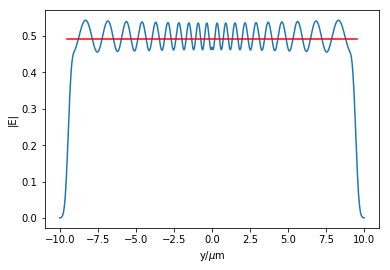

In [80]:
plt.figure()
plt.plot(np.linspace(-vac_height/2, vac_height/2,ez.shape[0]), ezmag[:,int(ez.shape[1]/2)])
plt.plot([-cut, cut],[the_mean]*2,'r')
plt.xlabel('y/$\mu$m')
plt.ylabel('|E|')
plt.show()

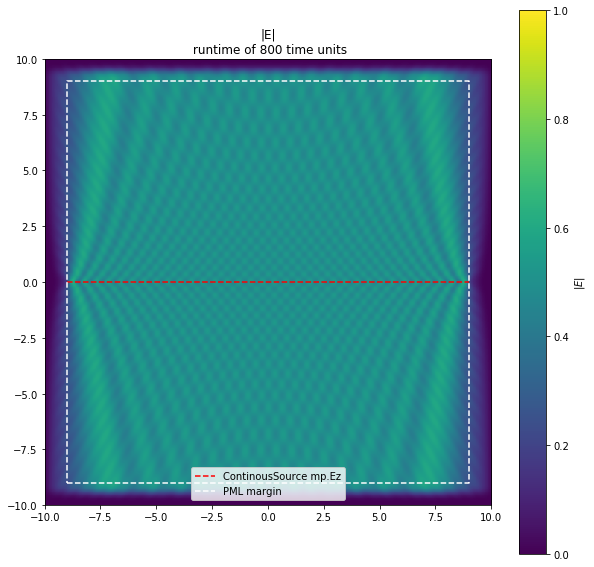

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(ezmag,extent=[-vac_width/2,vac_width/2,-vac_height/2,vac_height/2],
           vmin=0,vmax=1)
plt.plot([-vac_width/2+pml_margin,vac_width/2-pml_margin],[0,0],'r--',label='ContinousSource mp.Ez')
plt.plot([-vac_width/2+pml_margin,vac_width/2-pml_margin,vac_width/2-pml_margin,-vac_width/2+pml_margin,-vac_width/2+pml_margin],
         [-vac_width/2+pml_margin,-vac_width/2+pml_margin,vac_width/2-pml_margin,vac_width/2-pml_margin,-vac_width/2+pml_margin],'w--',
        label='PML margin')
plt.colorbar(label='$|E|$')
plt.legend()
plt.title('|E|\n runtime of %.0f time units' % sim_time)
plt.show()

In [ ]:


metalens_params['run_time_in_s'] = time.time() - start_time
metalens_params['fields'] = {'Ez': ez}
pickle.dump(metalens_params, open('%smetalens-%s.pkl' % (datadir, metalens_params['sim_id']),'wb'))

## 0.5 NA, aperture of 100 um, 250 nm pitch - 1555079806, p polarization, on axis

### S4 - bootstrap

In [16]:
simulation_parameters = {
                        'wavelength': 0.532,
                        'post_width': 0.075,
                        'post_height': 0.600,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0, 'p_amp': 1
                        }
simulation_parameters = expand_sim_params(simulation_parameters)

In [17]:
results = post_phase(simulation_parameters)

In [18]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

0.19788460213739065


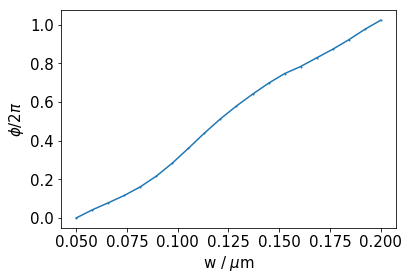

In [19]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [20]:
pickle.dump({'post_widths':post_widths,'phases': phases, 'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### MEEP - run

In [21]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [22]:
metalens_params = {'post_height':simulation_parameters['post_height'],
                  'NA':0.5,
                  'polarization': 'p',
                  'aperture': 100,
                  'sub_thickness': 5,
                  'air_space': 100,
                  'unit cell size': simulation_parameters['cell_width'],
                  'epsilon': simulation_parameters['epsilon'],
                  'phases': phases,
                  'widths': post_widths,
                  'wavelength': simulation_parameters['wavelength'],
                  'min_width': 0.05,
                  'pml width': 1,
                  'resolution': 30.,
                  'sim_id': simulation_parameters['sim_id'],
                  'simulation_parameters' : simulation_parameters,
                  'complex_fields' : False,
                  'axial_offset': 0}

metalens_params = aux_params(metalens_params)

metalens_params, geometry = make_metalens_geometry(metalens_params)

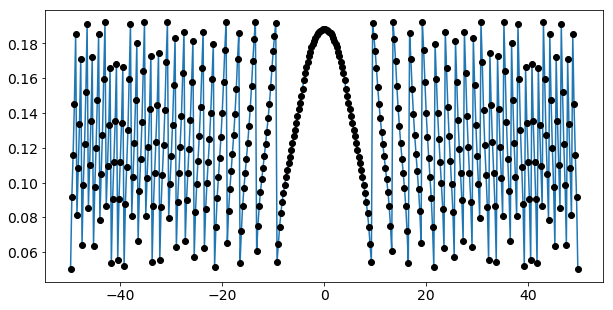

In [23]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,5))
plt.plot(metalens_params['axis_positions'],metalens_params['required_widths'])
plt.plot(metalens_params['axis_positions'],metalens_params['required_widths'],'ko')
plt.show()

In [12]:
# # Setup the MEEP objects
# cell = mp.Vector3(metalens_params['aperture'],
#                   metalens_params['H'])
# # All around the simulation cell
# pml_layers = [mp.PML(metalens_params['pml width'])]

# # Let sources be continuous
# sources = [mp.Source(src=mp.ContinuousSource(wavelength=metalens_params['wavelength'],
#                                              width = metalens_params['source width']),
#                     component=mp.Ez,
#                     center=mp.Vector3(0,metalens_params['source_offset']),
#                     size=mp.Vector3(metalens_params['aperture'] - 2*metalens_params['pml width'],0))]

# sim = mp.Simulation(cell_size=cell,
#                    boundary_layers=pml_layers,
#                    geometry=geometry,
#                    force_complex_fields = metalens_params['complex_fields'],
#                    sources=sources,
#                    resolution=metalens_params['resolution'])
# start_time = time.time()
# metalens_params['run_date'] = datetime.datetime.now().strftime("%b %d %Y at %H:%M:%S")

# sim.init_sim()
# sim.run(until=1*metalens_params['simulation time'])

# eps = sim.get_array(component=mp.Dielectric).transpose()
# ez = sim.get_array(component=mp.Ez).transpose()

# metalens_params['run_time_in_s'] = time.time() - start_time
# metalens_params['fields'] = {'Ez': ez}
# pickle.dump(metalens_params, open('%smetalens-%s.pkl' % (datadir, metalens_params['sim_id']),'wb'))

In [26]:
metal = pickle.load(open('metalens-1555098930.pkl','rb'))

In [14]:
# metal = metalens(metalens_params)

-----------
Initializing structure...
Meep progress: 4.1000000000000005/212.87773673567906 = 1.9% done in 4.0s, 204.8s to go
Meep progress: 8.450000000000001/212.87773673567906 = 4.0% done in 8.0s, 194.5s to go
Meep progress: 12.875/212.87773673567906 = 6.0% done in 12.0s, 187.1s to go
Meep progress: 17.125/212.87773673567906 = 8.0% done in 16.1s, 183.6s to go
Meep progress: 21.25/212.87773673567906 = 10.0% done in 20.1s, 181.0s to go
Meep progress: 25.375/212.87773673567906 = 11.9% done in 24.1s, 177.9s to go
Meep progress: 29.5/212.87773673567906 = 13.9% done in 28.1s, 174.7s to go
Meep progress: 33.6/212.87773673567906 = 15.8% done in 32.1s, 171.3s to go
Meep progress: 37.725/212.87773673567906 = 17.7% done in 36.1s, 167.7s to go
Meep progress: 41.800000000000004/212.87773673567906 = 19.6% done in 40.1s, 164.2s to go
Meep progress: 45.875/212.87773673567906 = 21.5% done in 44.1s, 160.6s to go
Meep progress: 49.875/212.87773673567906 = 23.4% done in 48.1s, 157.3s to go
Meep progress:

In [27]:
extent = [-metal['aperture']/2,
                       metal['aperture']/2,
                      -metal['H']/2-metal['top_of_posts_coordinate'],
                      metal['H']/2-metal['top_of_posts_coordinate']]

In [28]:
ez = metal['fields']['Ez']
e2 = np.abs(ez)**2

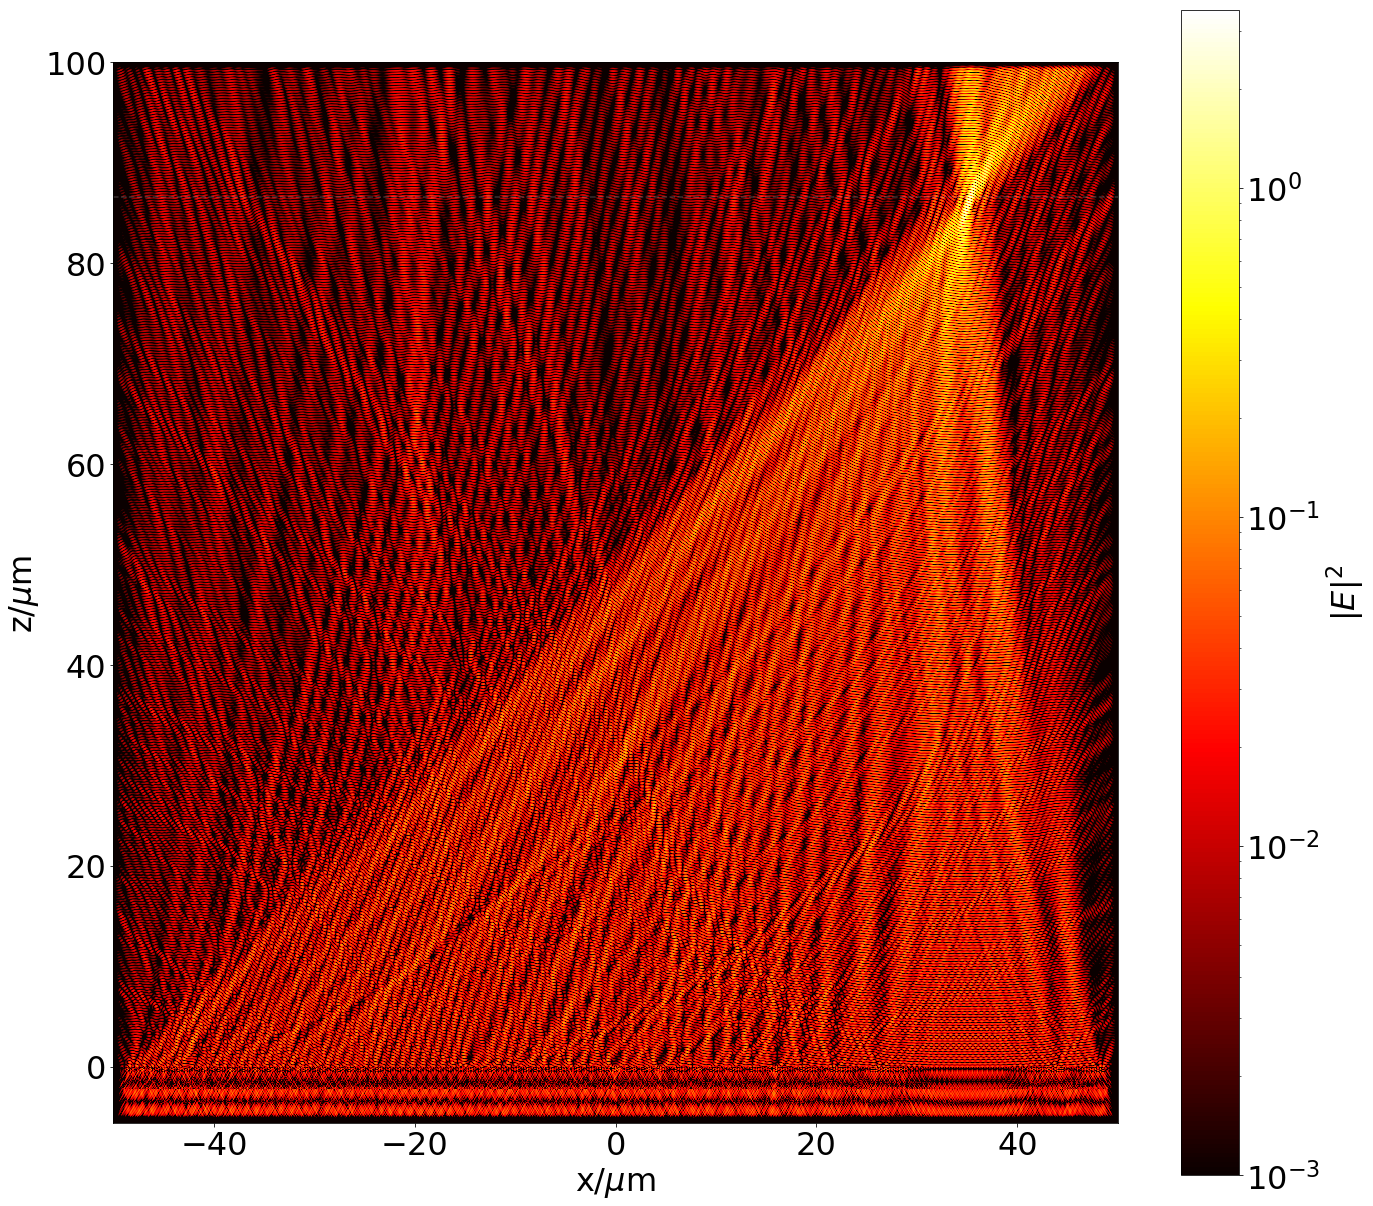

In [37]:
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*np.abs(ez)**2,extent=extent,
          cmap = 'hot',
          origin='lower',
          norm=LogNorm(vmin=0.001))
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metal['aperture']/2,metal['aperture']/2],
        [metal['f']]*2,'w--',alpha=0.2)
plt.colorbar(label='$|E|^2$')
plt.tight_layout()
plt.show()

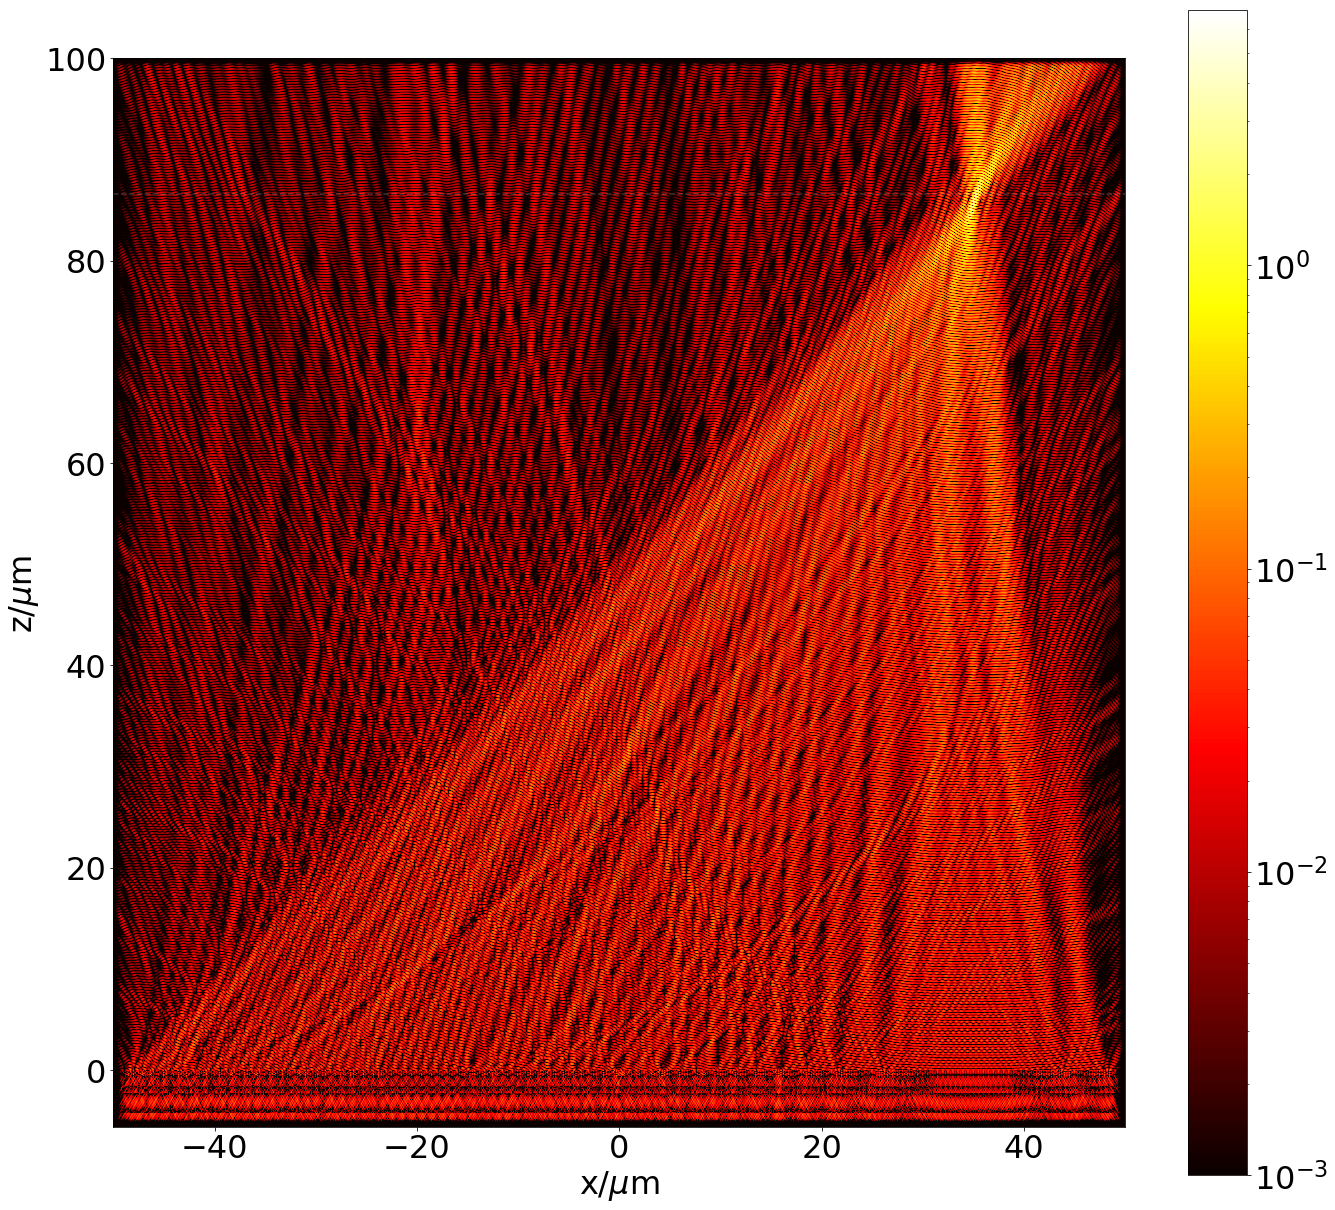

In [30]:
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*np.abs(ez)**2,extent=extent,
          cmap = 'hot',
          origin='lower',
          norm=LogNorm(vmin=0.001, vmax=np.max(np.abs(ez)**2)))
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metal['aperture']/2,metal['aperture']/2],
        [metal['f']]*2,'w--',alpha=0.2)
plt.colorbar()
plt.tight_layout()
plt.show()

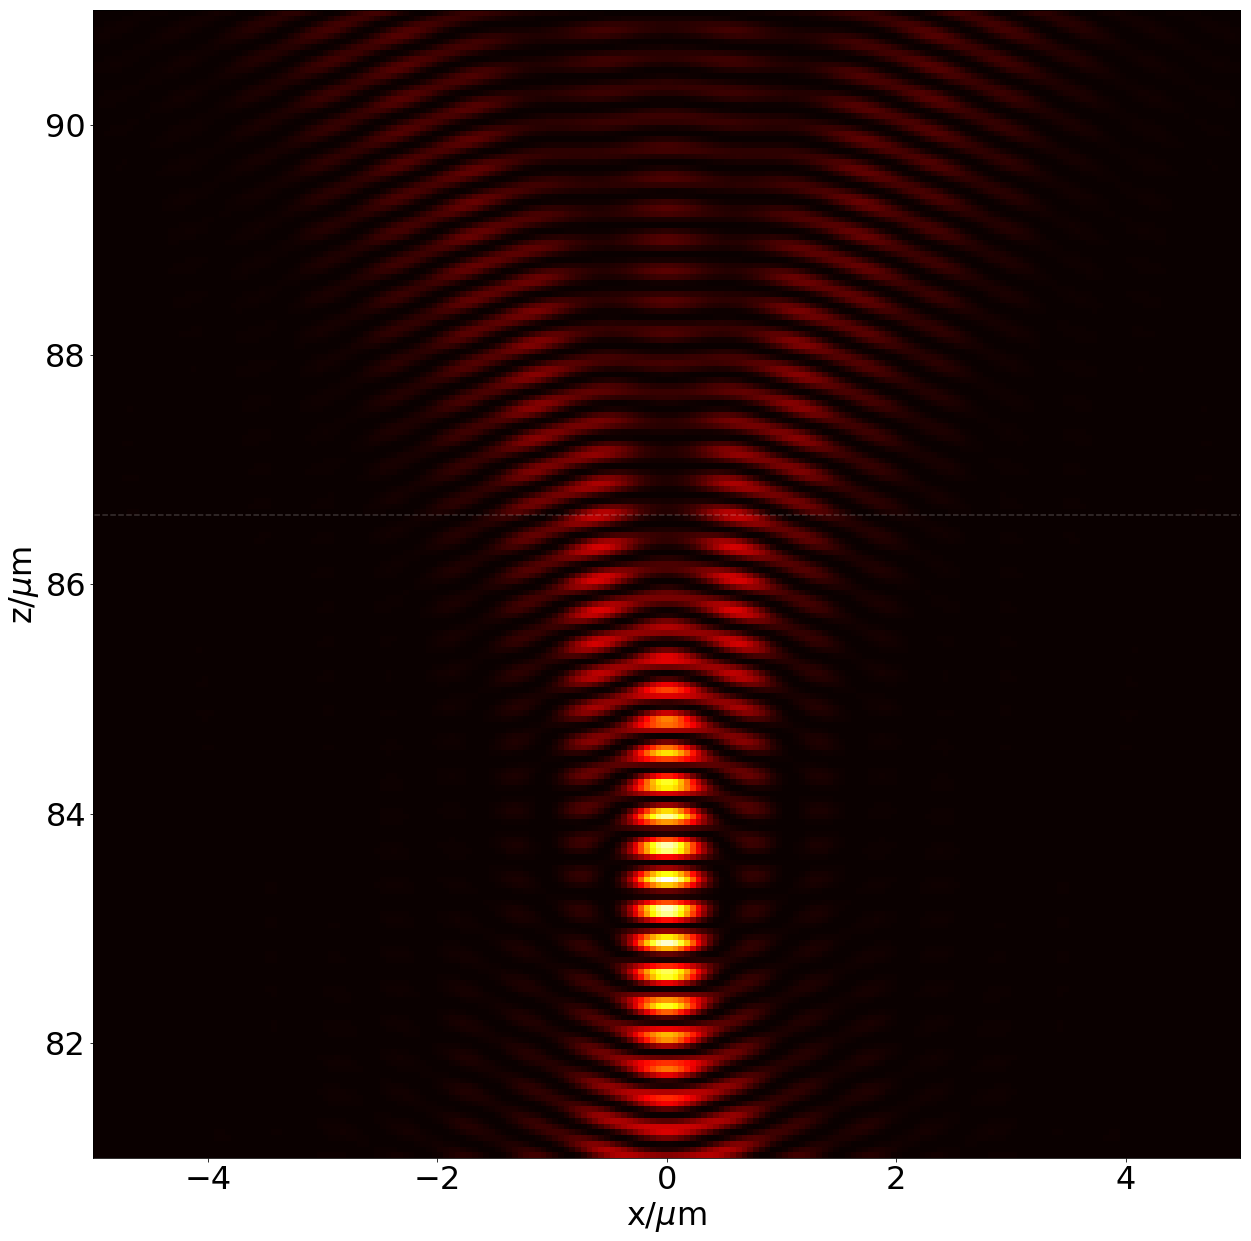

In [24]:
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*e2,extent=extent,
          cmap = 'hot',
          origin='lower')
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metal['aperture']/2,metal['aperture']/2],
        [metal['f']]*2,'w--',alpha=0.2)
plt.xlim(-5,5)
plt.ylim(81,91)
plt.tight_layout()
plt.show()

In [51]:
def pmetalens(metalens_params, num_cores):
    # save the params to disk
    pickle.dump(metalens_params, open('metalens_params_temp.pkl','wb'))
    # compose the script to be run
    script = '''

main_dir = '/Users/juan/Google Drive/Zia Lab/CEM/MEEP'
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import os
os.chdir(main_dir)

import uuid
import subprocess
import pickle
import time
import sys
sys.path.append(os.getcwd())
from metalens import *
import datetime

metalens_params = pickle.load(open('metalens_params_temp.pkl','rb'))
metalens_params = aux_params(metalens_params)
metalens_params = metalens(metalens_params)
pickle.dump(metalens_params, open(os.path.join(main_dir,'out.pkl'), 'wb'))
print('done')
    '''
    script_fname = 'pmeep-hack-%s.py' % str(uuid.uuid4())
    # save the python script to the playground dir
    with open(script_fname,'w') as f:
        f.write(script)
    command_sequence = ''.join(['source activate pmeep; ',
              'mpirun -n %d python %s' % (num_cores, script_fname)])
    print(command_sequence)
    !{command_sequence}
    out = pickle.load(open('out.pkl','rb'))
    os.system('mv out.pkl metalens-%s.pkl' % metalens_params['sim_id'])
    return out

In [66]:
metal = pmetalens(metalens_params, 8)

source activate pmeep; mpirun -n 8 python pmeep-hack-a83583e2-d904-4383-8a3d-cc51980d86d9.py
Working in 2D dimensions.
Computational cell is 100 x 105.6 x 0 with resolution 50
     block, center = (0,-50.3,0)
          size (100,5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49.75,-47.5,0)
          size (0.05,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49.5,-47.5,0)
          size (0.0914785,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49.25,-47.5,0)
          size (0.116089,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49,-47.5,0)
          size (0.144946,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)


subpixel-averaging is 61.2245% done, 2.53437 s remaining
subpixel-averaging is 65.0327% done, 2.1508 s remaining
subpixel-averaging is 66.3346% done, 2.03006 s remaining
time for set_epsilon = 20.0182 s
-----------
on time step 68 (time=0.68), 0.0591254 s/step
on time step 144 (time=1.44), 0.0530288 s/step
on time step 221 (time=2.21), 0.0524106 s/step
on time step 298 (time=2.98), 0.0521293 s/step
on time step 376 (time=3.76), 0.0517824 s/step
on time step 453 (time=4.53), 0.052134 s/step
on time step 529 (time=5.29), 0.053208 s/step
on time step 605 (time=6.05), 0.0530035 s/step
on time step 682 (time=6.82), 0.0522151 s/step
on time step 758 (time=7.58), 0.0530359 s/step
on time step 835 (time=8.35), 0.0524878 s/step
on time step 911 (time=9.11), 0.0533087 s/step
on time step 988 (time=9.88), 0.0520497 s/step
on time step 1065 (time=10.65), 0.0519979 s/step
on time step 1142 (time=11.42), 0.0523395 s/step
on time step 1217 (time=12.17), 0.0537322 s/step
on time step 1294 (time=12.94)

on time step 11816 (time=118.16), 0.055591 s/step
on time step 11886 (time=118.86), 0.0573957 s/step
on time step 11955 (time=119.55), 0.0583356 s/step
on time step 12025 (time=120.25), 0.0577467 s/step
on time step 12093 (time=120.93), 0.0593149 s/step
on time step 12162 (time=121.62), 0.0586529 s/step
on time step 12232 (time=122.32), 0.0573083 s/step
on time step 12301 (time=123.01), 0.0583677 s/step
on time step 12373 (time=123.73), 0.0563009 s/step
on time step 12442 (time=124.42), 0.0586219 s/step
on time step 12513 (time=125.13), 0.0563383 s/step
on time step 12584 (time=125.84), 0.0570995 s/step
on time step 12652 (time=126.52), 0.059106 s/step
on time step 12722 (time=127.22), 0.0578156 s/step
on time step 12792 (time=127.92), 0.0574753 s/step
on time step 12863 (time=128.63), 0.0566575 s/step
on time step 12935 (time=129.35), 0.0557293 s/step
on time step 13007 (time=130.07), 0.0558168 s/step
on time step 13078 (time=130.78), 0.0570072 s/step
on time step 13148 (time=131.48),

on time step 14926 (time=149.26), 0.0561556 s/step
on time step 14996 (time=149.96), 0.0575052 s/step
on time step 15067 (time=150.67), 0.0569371 s/step
on time step 15137 (time=151.37), 0.0571684 s/step
on time step 15207 (time=152.07), 0.0572827 s/step
on time step 15279 (time=152.79), 0.0558257 s/step
on time step 15351 (time=153.51), 0.0560884 s/step
on time step 15421 (time=154.21), 0.057414 s/step
on time step 15493 (time=154.93), 0.0558732 s/step
on time step 15561 (time=155.61), 0.0590029 s/step
on time step 15632 (time=156.32), 0.0566997 s/step
on time step 15702 (time=157.02), 0.0574888 s/step
on time step 15774 (time=157.74), 0.056185 s/step
on time step 15845 (time=158.45), 0.0566243 s/step
on time step 15915 (time=159.15), 0.0577218 s/step
on time step 15986 (time=159.86), 0.0567004 s/step
on time step 16058 (time=160.58), 0.0561759 s/step
on time step 16129 (time=161.29), 0.0567968 s/step
on time step 16200 (time=162), 0.0569974 s/step
on time step 16270 (time=162.7), 0.0

In [67]:
os.system('ding &')

0

In [78]:
metal['run_time_in_s'] / 60.

20.353062697251637

In [79]:
ez = metal['fields']['Ez']

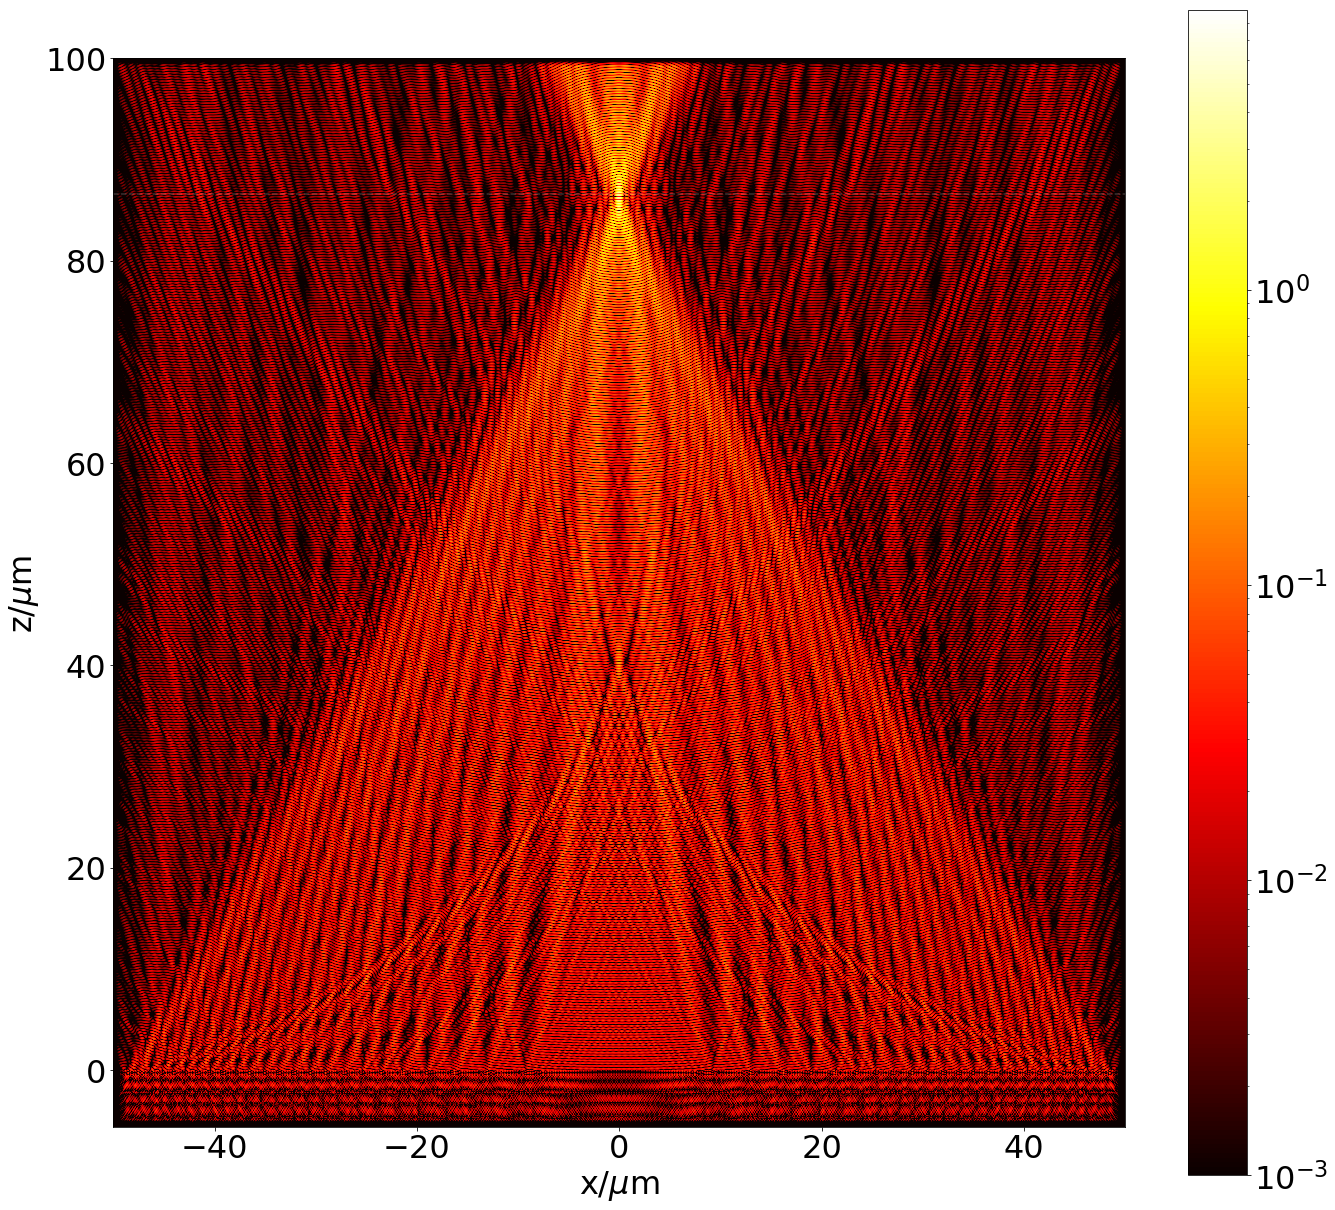

In [80]:
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*np.abs(ez)**2,extent=extent,
          cmap = 'hot',
          origin='lower',
          norm=LogNorm(vmin=0.001, vmax=np.max(np.abs(ez)**2)))
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metalens_params['aperture']/2,metalens_params['aperture']/2],
        [metalens_params['f']]*2,'w--',alpha=0.2)
plt.colorbar()
plt.tight_layout()
plt.show()

## 0.5 NA, aperture of 100 um, 250 nm pitch - 1555079806, p polarization, off axis

### S4 - bootstrap

In [121]:
simulation_parameters = {
                        'wavelength': 0.637,
                        'post_width': 0.075,
                        'post_height': 0.8,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0,
                        'p_amp': 1
                        }
simulation_parameters = expand_sim_params(simulation_parameters)

In [122]:
results = post_phase(simulation_parameters)

In [125]:
post_widths = np.linspace(0.05,0.2,21)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

0.1816089229804788


In [127]:
hopes = np.array([0.        , 0.0418385 , 0.08075696, 0.11913915, 0.16067393,
       0.20923524, 0.26680874, 0.33102356, 0.39626989, 0.45898382,
       0.5200362 , 0.58277487, 0.65056736, 0.72429042, 0.79973771,
       0.86942631, 0.92912465, 0.97992505, 1.02550966, 1.07024258,
       1.11895178])

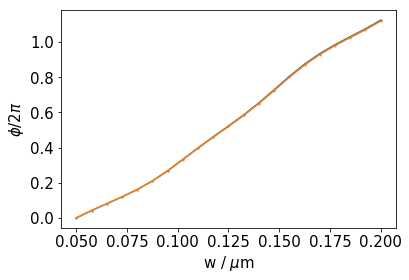

In [129]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.plot(post_widths,hopes,'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [48]:
pickle.dump({'post_widths':post_widths,'phases': phases, 'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### Phase dependence on post width and height

In [3]:
from joblib import Parallel, delayed
import multiprocessing

In [120]:
simulation_parameters

{'wavelength': 0.637,
 'post_width': 0.075,
 'post_height': 0.6,
 'cell_width': 0.25,
 'epsilon': 5.8418,
 'num_G': 70,
 'x_coord': 0,
 'y_coord': 0,
 'sim_id': '1555444548',
 's_amp': 0,
 'p_amp': 1,
 'field_height': 0.6,
 'half_cell_width': 0.125,
 'half_post_width': 0.0375,
 'excitation_frequency': 1.5698587127158556}

In [96]:
def get_all_phases(post_widths, post_height, simulation_parameters):
    phases = []
    simulation_parameters['post_height'] = post_height
    simulation_parameters['field_height'] = simulation_parameters['post_height']
    for p_width in post_widths:
        simulation_parameters['post_width'] = p_width
        simulation_parameters = expand_sim_params(simulation_parameters)
        results = post_phase(simulation_parameters)
        Exr = results[0]
        Eyr = results[1]
        Ezr = results[2]
        Exi = results[3]
        Eyi = results[4]
        Ezi = results[5] 
        phases.append(np.arctan2(Exi, Exr))
    phases = np.array(phases)
    phases = np.unwrap(phases)
    phases = phases - phases[0]
    return phases

In [97]:
post_transmission(simulation_parameters)

array([0.93081336, 0.        , 0.        , 0.        ])

In [98]:
def get_all_transmissions(post_widths, post_height, simulation_parameters):
    trans = []
    simulation_parameters['post_height'] = post_height
    simulation_parameters['field_height'] = simulation_parameters['post_height']
    for p_width in post_widths:
        simulation_parameters['post_width'] = p_width
        simulation_parameters = expand_sim_params(simulation_parameters)
        trans.append(post_transmission(simulation_parameters)[0])
    return np.array(trans)

In [116]:
post_heights = np.linspace(0.05,2,61)#[1:]
post_widths = np.linspace(0.05,0.2,61)
print("doing phases ...")
all_phases = Parallel(n_jobs=8)(delayed(get_all_phases)(post_widths, post_height, simulation_parameters) for post_height in post_heights)
all_phases = np.array(all_phases)
print("doing transmissions ...")
all_transmission = Parallel(n_jobs=8)(delayed(get_all_transmissions)(post_widths, post_height, simulation_parameters) for post_height in post_heights)
all_transmission = np.array(all_transmission)

doing phases ...
doing transmissions ...


In [117]:
2*np.pi*simulation_parameters['wavelength']/np.sqrt(simulation_parameters['epsilon'])

1.6559451918975696

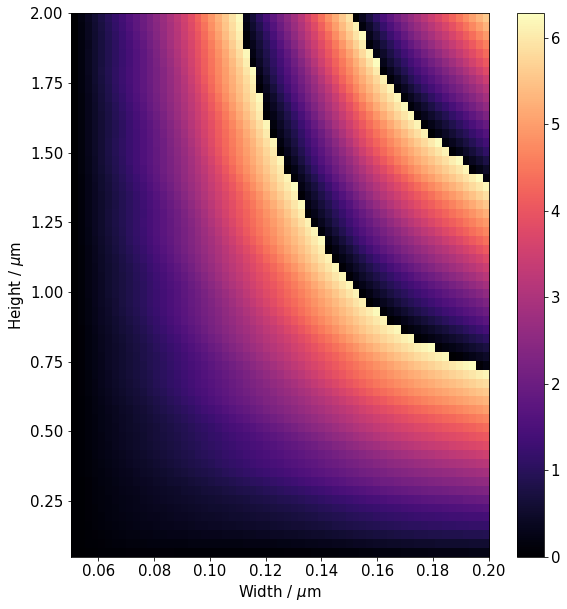

In [134]:
plt.figure(figsize=(10,10))
plt.imshow((all_phases)%(2*np.pi),
           extent = [min(post_widths),max(post_widths),min(post_heights),max(post_heights)],
           aspect=0.1,
           cmap='magma',
           origin='lower')
plt.colorbar()
plt.xlabel('Width / $\mu$m')
plt.ylabel('Height / $\mu$m')
plt.show()

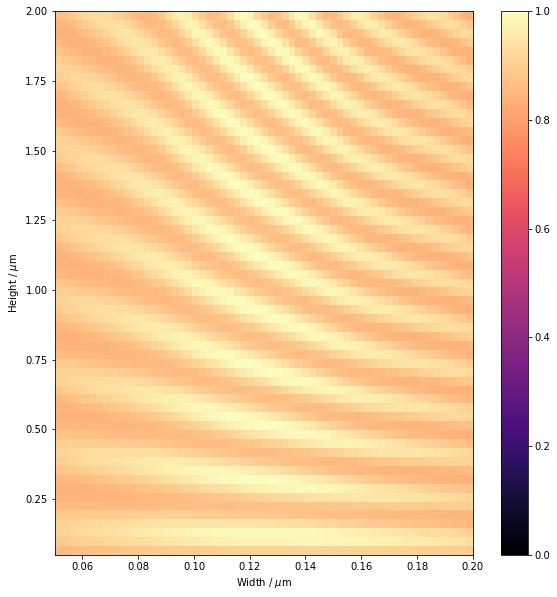

In [119]:
plt.figure(figsize=(10,10))
plt.imshow(all_transmission,
           extent = [min(post_widths),max(post_widths),min(post_heights),max(post_heights)],
           aspect=0.1,
           cmap='magma',
           vmin=0,
           vmax=1,
           origin='lower')
plt.colorbar()
plt.xlabel('Width / $\mu$m')
plt.ylabel('Height / $\mu$m')
plt.show()

### MEEP - run

In [7]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [8]:
metalens_params = {'post_height':simulation_parameters['post_height'],
                  'NA':0.5,
                  'polarization': 'p',
                  'aperture': 100,
                  'sub_thickness': 5,
                  'air_space': 100,
                  'unit cell size': simulation_parameters['cell_width'],
                  'epsilon': simulation_parameters['epsilon'],
                  'phases': phases,
                  'widths': post_widths,
                  'wavelength': simulation_parameters['wavelength'],
                  'min_width': 0.05,
                  'pml width': 1,
                  'resolution': 10.,
                  'sim_id': simulation_parameters['sim_id'],
                  'simulation_parameters' : simulation_parameters,
                  'complex_fields' : False,
                  'axial_offset': 35}

metalens_params = aux_params(metalens_params)

metalens_params, geometry = make_metalens_geometry(metalens_params)

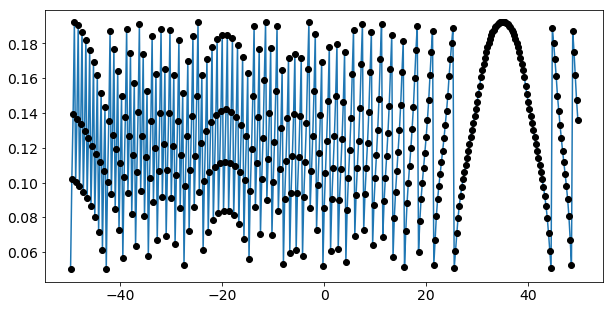

In [9]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,5))
plt.plot(metalens_params['axis_positions'],metalens_params['required_widths'])
plt.plot(metalens_params['axis_positions'],metalens_params['required_widths'],'ko')
plt.show()

In [66]:
# metal = metalens(metalens_params)

-----------
Initializing structure...


KeyboardInterrupt: 

In [ ]:
# extent = [-metal['aperture']/2,
#                        metal['aperture']/2,
#                       -metal['H']/2-metal['top_of_posts_coordinate'],
#                       metal['H']/2-metal['top_of_posts_coordinate']]

In [ ]:
# ez = metal['fields']['Ez']
# e2 = np.abs(ez)**2

In [ ]:
# plt.rcParams.update({'font.size': 32})
# plt.figure(figsize=(20,18))
# plt.imshow(1/2*np.abs(ez)**2,extent=extent,
#           cmap = 'hot',
#           origin='lower')
# plt.xlabel('x/$\mu$m')
# plt.ylabel('z/$\mu$m')
# plt.plot([-metal['aperture']/2,metal['aperture']/2],
#         [metal['f']]*2,'w--',alpha=0.2)
# plt.colorbar()
# plt.tight_layout()
# plt.show()

In [ ]:
# plt.rcParams.update({'font.size': 32})
# plt.figure(figsize=(20,18))
# plt.imshow(1/2*np.abs(ez)**2,extent=extent,
#           cmap = 'hot',
#           origin='lower',
#           norm=LogNorm(vmin=0.001, vmax=np.max(np.abs(ez)**2)))
# plt.xlabel('x/$\mu$m')
# plt.ylabel('z/$\mu$m')
# plt.plot([-metal['aperture']/2,metal['aperture']/2],
#         [metal['f']]*2,'w--',alpha=0.2)
# plt.colorbar()
# plt.tight_layout()
# plt.show()

In [ ]:
# plt.rcParams.update({'font.size': 32})
# plt.figure(figsize=(20,18))
# plt.imshow(1/2*e2,extent=extent,
#           cmap = 'hot',
#           origin='lower')
# plt.xlabel('x/$\mu$m')
# plt.ylabel('z/$\mu$m')
# plt.plot([-metal['aperture']/2,metal['aperture']/2],
#         [metal['f']]*2,'w--',alpha=0.2)
# plt.xlim(-5,5)
# plt.ylim(81,91)
# plt.tight_layout()
# plt.show()

In [67]:
# def pmetalens(metalens_params, num_cores):
#     # save the params to disk
#     pickle.dump(metalens_params, open('metalens_params_temp.pkl','wb'))
#     # compose the script to be run
#     script = '''

# main_dir = '/Users/juan/Google Drive/Zia Lab/CEM/MEEP'
# import meep as mp
# import numpy as np
# from matplotlib import pyplot as plt
# import os
# os.chdir(main_dir)

# import uuid
# import subprocess
# import pickle
# import time
# import sys
# sys.path.append(os.getcwd())
# from metalens import *
# import datetime

# metalens_params = pickle.load(open('metalens_params_temp.pkl','rb'))
# metalens_params = aux_params(metalens_params)
# metalens_params = metalens(metalens_params)
# pickle.dump(metalens_params, open(os.path.join(main_dir,'out.pkl'), 'wb'))
# print('done')
#     '''
#     script_fname = 'pmeep-hack-%s.py' % str(uuid.uuid4())
#     # save the python script to the playground dir
#     with open(script_fname,'w') as f:
#         f.write(script)
#     command_sequence = ''.join(['source activate pmeep; ',
#               'mpirun -n %d python %s' % (num_cores, script_fname)])
#     print(command_sequence)
#     !{command_sequence}
#     out = pickle.load(open('out.pkl','rb'))
#     os.system('mv out.pkl metalens-%s.pkl' % metalens_params['sim_id'])
#     return out

In [11]:
metalens_params['resolution'] = 30
metal = para_metalens(metalens_params, 8)

source activate pmeep; mpirun -n 8 python pmeep-hack-7c634dea-0858-40ba-bbcc-2f0f0569aefc.py


In [69]:
os.system('ding &')

0

In [12]:
metal['run_time_in_s'] / 60.

4.243240269025167

In [13]:
ez = metal['fields']['Ez']

In [15]:
extent = [-metal['aperture']/2,
                       metal['aperture']/2,
                      -metal['H']/2-metal['top_of_posts_coordinate'],
                      metal['H']/2-metal['top_of_posts_coordinate']]

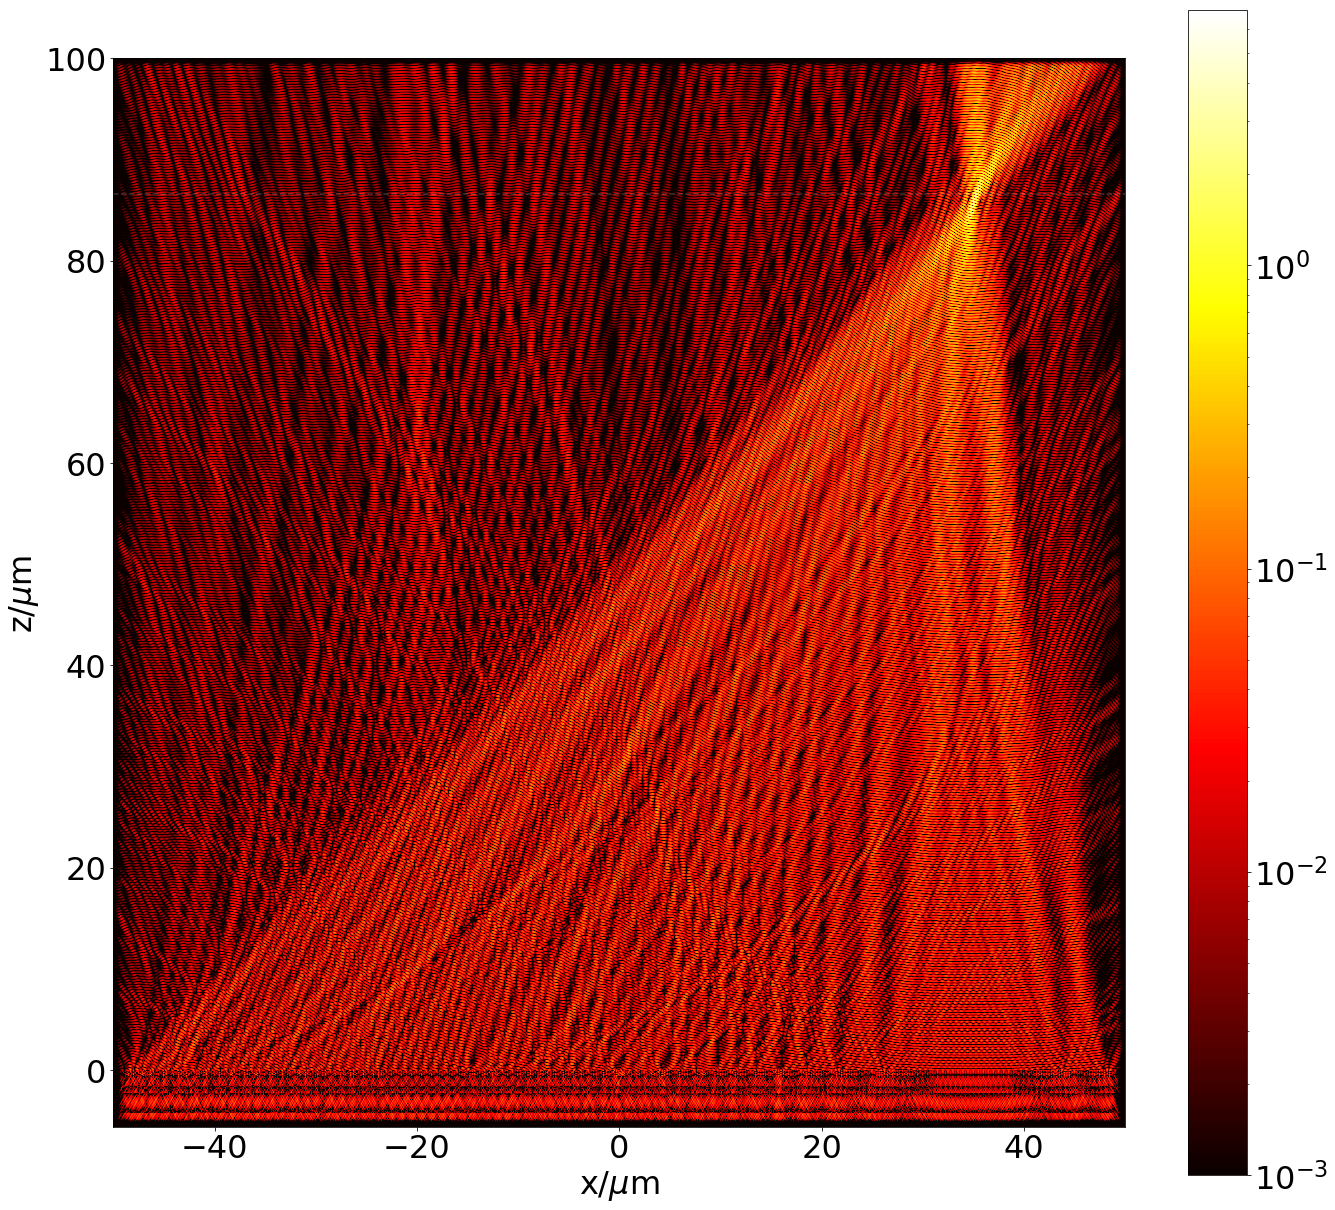

In [16]:
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*np.abs(ez)**2,extent=extent,
          cmap = 'hot',
          origin='lower',
          norm=LogNorm(vmin=0.001, vmax=np.max(np.abs(ez)**2)))
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metalens_params['aperture']/2,metalens_params['aperture']/2],
        [metalens_params['f']]*2,'w--',alpha=0.2)
plt.colorbar()
plt.tight_layout()
plt.show()

In [82]:
print(tabulate([k, metal[k]] for k in metal if (type(metal[k]) != list) and (type(metal[k]) != np.ndarray) and (type(metal[k]) != dict)))

-----------------------  -----------------------
post_height              0.6
NA                       0.5
polarization             p
aperture                 100
sub_thickness            5
air_space                100
unit cell size           0.25
epsilon                  5.8418
wavelength               0.532
min_width                0.05
pml width                1
resolution               30
sim_id                   1555094054
complex_fields           False
axial_offset             35
num of unit cells        399
f                        86.60254037844386
fcen                     1.8796992481203008
n                        2.4169815886762565
H                        105.6
top_of_posts_coordinate  -47.199999999999996
source_offset            -49.396
near2far_offset          -45.604
f#                       1.1547005383792515
source width             1.064
simulation time          212.87773673567906
run_date                 Apr 12 2019 at 14:53:09
run_time_in_s            261.519881010

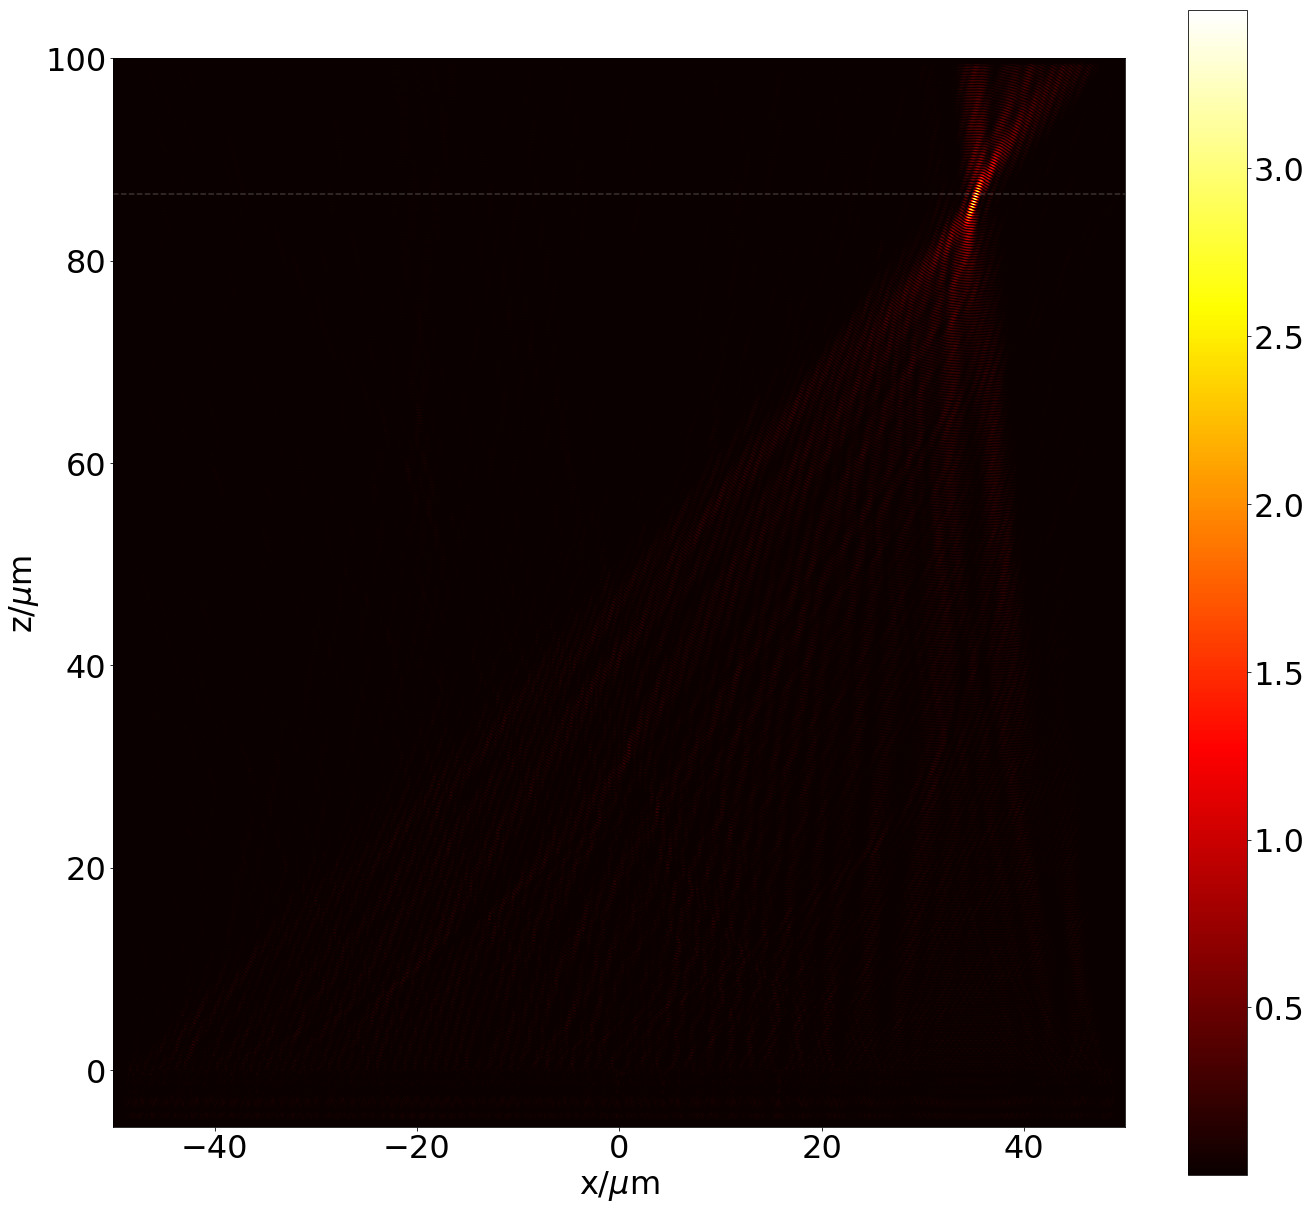

In [73]:
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*np.abs(ez)**2,extent=extent,
          cmap = 'hot',
          origin='lower')
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metalens_params['aperture']/2,metalens_params['aperture']/2],
        [metalens_params['f']]*2,'w--',alpha=0.2)
plt.colorbar()
plt.tight_layout()
plt.show()